<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
# Load the TensorBoard not|ebook extension

## KITTI

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import Kitti, VisionDataset

import torch.utils.data
from torch.utils.data import DataLoader
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
class Kitti_v2(Kitti):
    def __init__(self, *args, **kwargs):
        super(Kitti_v2, self).__init__(*args, **kwargs)

In [ ]:
torch.manual_seed(0)

<torch._C.Generator>

In [ ]:
path = './Data/Kitti_depth'

# desired_size = (round(375), round(1242))
desired_size = (250, 500)

In [ ]:
transform2 = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size = desired_size),  # Resize image
        v2.RandomPhotometricDistort(p=0.2),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=0.4),
        # # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
# Load KITTI train dataset
train_dataset = Kitti_v2(root=path, train='true', download=True, transforms=transform2)

# Load KITTI test dataset
test_dataset = Kitti_v2(root=path, train='false', download=True, transforms=transform2)

In [ ]:
sample = train_dataset[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'list'>


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels"))

In [ ]:
len(train_dataset2), len(test_dataset2)

(7481, 7481)

In [ ]:
classes = 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'.split()

In [ ]:
sample = train_dataset2[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    if 'scores' in label:
        for bbox, item, score in zip(label['boxes'], label['labels'], label['scores']):
            if score > 0.2:
                cv2.rectangle(image_cv2,
                              (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                              (0, 255, 0), 2)
            
                # Display the label
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image_cv2, classes[item],
                            (int(bbox[0]), int(bbox[1]) - 10),
                            font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        for bbox, item in zip(label['boxes'], label['labels']):
            # Draw the bounding box
            cv2.rectangle(image_cv2,
                          (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                          (0, 255, 0), 2)
        
            # Display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_cv2, classes[item],
                        (int(bbox[0]), int(bbox[1]) - 10),
                        font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb

def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(math.sqrt(len(images)))
    ncols = int(np.floor(len(images)/nrows))
        
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the image using Matplotlib
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        
        # Display image
        ax.imshow(image_rgb)
        ax.axis('off')

    for ax in axes.flat[len(images):]:
        ax.axis('off')
    plt.show()

In [ ]:
batch_size = 4

train_loader = DataLoader(train_dataset2,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)),
                          num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)

In [ ]:
image, label = train_dataset2[18]
image.shape

torch.Size([3, 250, 500])

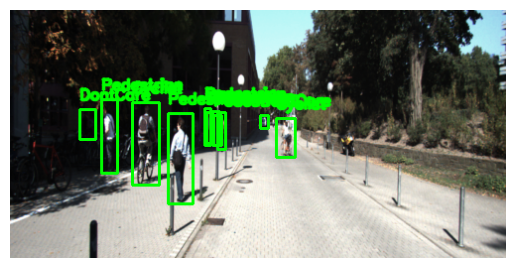

In [ ]:
show_image(train_dataset2[18])

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)

In [ ]:
type(images[1])

torchvision.tv_tensors._image.Image

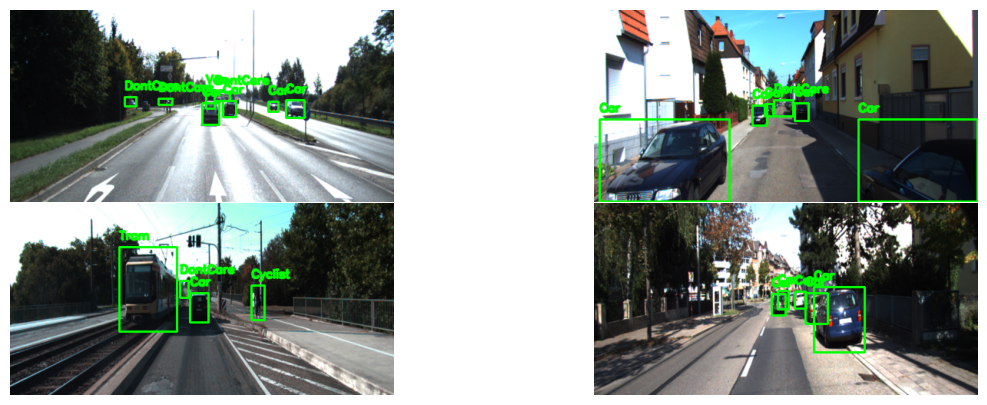

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
# Define a function to display images
def board_images(images, labels, **kwargs):
    new_images = []
    for image, label in zip(images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        new_images.append(image_rgb)

    return torch.stack([torch.tensor(array) for array in new_images])

In [ ]:
images[1].shape

torch.Size([3, 250, 500])

In [ ]:
tensor = board_images(images, labels)

In [ ]:
# ############## TENSORBOARD ########################
# nrows = int(math.sqrt(len(tensor)))
# nrows = int(len(tensor) / nrows)
# img_grid = torchvision.utils.make_grid(images[1],
#                                        nrow = nrows,
#                                        padding = 2)

# writer.add_image('KITTI_images', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

### Model

In [ ]:
import torch 
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.transform import GeneralizedRCNNTransform

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# # Define the resize parameters
# min_size = (300,)  # Change this to your desired minimum size
# max_size = 500    # Change this to your desired maximum size

# # Define the transform
# transform3 = GeneralizedRCNNTransform(
#     image_mean=[0.485, 0.456, 0.406],
#     image_std=[0.229, 0.224, 0.225],
#     min_size=min_size,
#     max_size=max_size
# )

In [ ]:
# # Load the ResNet-18 backbone
# backbone = resnet_fpn_backbone('resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

# # Create the Faster R-CNN model with the modified transform
# model = FasterRCNN(backbone = backbone, num_classes=20, transform=transform3)
# model.transform.min_size = min_size
# model.transform.max_size = max_size
# model = model.to(device)

In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torch.nn import Conv2d

weights= FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT

model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights, box_score_thresh=0.5)
model.backbone.body['0'][0] = Conv2d(in_channels=4, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

updated_mean = [0.485, 0.456, 0.406, 0.406]
updated_std = [0.229, 0.224, 0.225, 0.225]
model.transform.image_mean = updated_mean
model.transform.image_std = updated_std

model = model.to(device)

In [ ]:
def start_tensorboard(file_name):
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    from datetime import datetime
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'{file_name} {formatted_time}')
    print(f'{file_name} {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    
    
    # writer.add_graph(model, images)
    writer.flush()
    ###################################################
    return writer

In [ ]:
len(train_loader)

1871

In [ ]:
# Evaluation loop
def eval_model(epoch, n_total_steps):
    model.train()
    total_loss = 0.0
    
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader):
            # Move input data to GPU
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
    ############## TENSORBOARD ########################
    writer.add_scalar('eval loss', total_loss / len(test_loader), epoch * n_total_steps)
    writer.flush()
    running_loss = 0.0
    ###################################################
    # Print average loss for the evaluation
    print(f"Average Loss (Evaluation): {total_loss / len(test_loader):.4f}")

In [ ]:
# Training loop
running_loss = 0.0
n_total_steps = len(train_loader)
# Define an optimizer (you can use any optimizer from torch.optim)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=0.9)
# Define optimizer and learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

epochs = 3

writer = start_tensorboard(f'kitti/start {epochs} {batch_size} {learning_rate}')


for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for i, (imgs, targets) in enumerate(tqdm(train_loader)):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        running_loss += losses.item()

        if (i+1) % 100 == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.flush()
            running_loss = 0.0
            ###################################################

    # Update learning rate scheduler
    lr_scheduler.step()
    eval_model(epoch, n_total_steps)
    
    # Print average loss for the epoch
    print(f"Average Loss: {total_loss / len(train_loader):.4f}")

kitti/start 3 4 0.001 06:32:40


 10%|███████▋                                                                        | 180/1871 [00:44<06:29,  4.34it/s]

In [ ]:
model.eval()
# Get a batch of images and labels from the data loader
examples = iter(test_loader)

In [ ]:
images, labels = next(examples)
imgs = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

In [ ]:
len(imgs)

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
type(labels)

In [ ]:
loss_dict = model(imgs)

In [ ]:
show_images(images, loss_dict, figsize=(15, 5))

In [ ]:
############## TENSORBOARD ########################
writer.close()
###################################################

## Eval

In [ ]:
def calculate_precision(prediction, target, iou_threshold=0.5):
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()

    target_boxes = target['boxes'].numpy()
    target_labels = target['labels'].numpy()

    num_preds = len(pred_boxes)
    num_targets = len(target_boxes)

    true_positives = np.zeros(num_preds)
    false_positives = np.zeros(num_preds)

    # Initialize an array to keep track of whether each ground truth box has been detected
    detected = np.zeros(num_targets)
    false_negatives = np.zeros(num_targets)

    for pred in range(num_preds):
        max_iou = 0
        max_idx = -1

        for targ in range(num_targets):
            iou = calculate_iou(pred_boxes[pred], target_boxes[targ])

            # Check if the prediction is a true positive
            if iou > iou_threshold and not detected[targ] and pred_labels[pred] == target_labels[targ]:
                true_positives[pred] = 1
                detected[targ] = 1

                # Update the maximum IoU and corresponding index
                if iou > max_iou:
                    max_iou = iou
                    max_idx = targ

        # If no true positive is found, the prediction is a false positive
        if true_positives[pred] == 0:
            false_positives[pred] = 1
            
    # Calculate false negatives
    false_negatives = 1 - detected
    
    # Calculate precision
    if num_preds:
        precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
    else:
        precision = 0
    # Calculate recall
    recall = np.sum(true_positives) / num_targets

    # Calculate accuracy
    accuracy = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives) + np.sum(false_negatives))

    return precision, recall, accuracy

In [ ]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

In [ ]:
# Run inference
model.eval()
predictions = []
targets_list = []
image_list = []
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        imgs = [img.to(device) for img in images]
        targets_list.extend(targets)
        image_list.extend(images)
        prediction = model(imgs)
        predictions.extend(prediction)

for prediction in predictions:
    for a in prediction:
        prediction[f'{a}'] = prediction[f'{a}'].to('cpu')